In [83]:
import math
import itertools
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import skfuzzy as fuzz
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_selection import mutual_info_regression
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [84]:
# =========================
#   EDITABLE PARAMETERS
# =========================
# Number of rules/clusters for the ANFIS (TSK) model and the global FCM fuzzification parameter
N_RULES = 5       
M_FCM = 2.0       # <— Fuzzification coefficient (m), typically set to 2.0

# Hybrid training settings for the ANFIS model
ANFIS_MAX_ITERS = 20   # Number of alternating iterations between GD (antecedents) and LS (consequents)
ANFIS_GD_EPOCHS = 200  # Number of gradient descent epochs per iteration
ANFIS_LR = 1e-4        # Learning rate used during gradient descent
AGG_PROB = False        # If True, use probabilistic intersection (L2 norm); if False, use min approximation via max(diff)

# Feature selection 
TOP_K_FEATURES = 6      
SHOW_CLUSTERING_PLOTS = True  # 👈 Set to False to disable clustering visualization plots


In [85]:
# ----------------------------
# 1) Load + preprocess dataset
# ----------------------------

def load_foods_dataset():
    # Load the public "foods-nutrition-dataset" from Hugging Face Datasets
    ds = load_dataset("adarshzolekar/foods-nutrition-dataset")
    
   
    split_name = "train" if "train" in ds else list(ds.keys())[0]
    df = pd.DataFrame(ds[split_name])

    # Convert string values that look numeric into proper numeric types
    for c in df.columns:
        if df[c].dtype == "object":
            df[c] = pd.to_numeric(df[c], errors="ignore")

    # Define the target (output) variable
    target_col = "Energy kcal"
    if target_col not in df.columns:
        raise RuntimeError("Expected 'Energy kcal' column not found in dataset.")

    # Keep only numeric columns, excluding the target variable
    num_cols = [c for c in df.columns if df[c].dtype.kind in "if"]
    num_cols = [c for c in num_cols if c != target_col]
    
    # Create a cleaned dataframe with numeric features and the target column
    df = df[num_cols + [target_col]].dropna()

    return df, target_col

# Load and preprocess the dataset
df, target_col = load_foods_dataset()
print(f"Detected target column: {target_col}")
print(f"Shape after cleaning: {df.shape}")


Detected target column: Energy kcal
Shape after cleaning: (1028, 8)


C:\Users\Gonçalo Rosa\AppData\Local\Temp\ipykernel_1568\757895464.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")


In [86]:
# Convert DataFrame to NumPy arrays for model processing
X_full = df.drop(columns=[target_col]).to_numpy(dtype=np.float32)
y_full = df[target_col].to_numpy(dtype=np.float32).reshape(-1, 1)

# Split the dataset into train, validation, and test sets
# (30% held out for val/test → then split evenly into 15% each)
X_train, X_tmp, y_train, y_tmp = train_test_split(X_full, y_full, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test   = train_test_split(X_tmp, y_tmp, test_size=0.50, random_state=42)

# Standardize features using statistics (mean, std) from the training set
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# ---- Top-k feature selection ----
# Evaluate the dependency between each feature and the target variable (calories)
k = min(TOP_K_FEATURES, X_train_s.shape[1])
mi = mutual_info_regression(X_train_s, y_train.ravel(), random_state=42)

# Select the indices of the top-k most informative features
top_idx = np.argsort(mi)[-k:]

# Retrieve the corresponding feature names for reporting
feature_names_all = df.drop(columns=[target_col]).columns.to_list()
selected_features = [feature_names_all[i] for i in top_idx]
print(f"Selected {k} features for TSK fuzzy rules: {selected_features}")

# Reduce all datasets (train/val/test) to include only the top-k selected features
X_train_s = X_train_s[:, top_idx]
X_val_s   = X_val_s[:, top_idx]
X_test_s  = X_test_s[:, top_idx]

# Store final feature count and confirm GPU/CPU device selection for PyTorch
n_features = X_train_s.shape[1]
print(f"Using {n_features} numeric features after selection.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



Selected 6 features for TSK fuzzy rules: ['Calcium(mg)', 'Protein(g)', 'Cholestrol(mg)', 'Freesugar(g)', 'Carbs', 'Fat(g)']
Using 6 numeric features after selection.


In [87]:
# ===========================================================
# 4A) GLOBAL FCM (A) over [X | y]
# ===========================================================
def fcm_global_init(Xtr_s, ytr, n_rules=N_RULES, m=M_FCM, seed=0):
    """
    Performs Fuzzy C-Means (FCM) clustering on the concatenated feature–target space [X | y].
    Returns:
        centers_global : ndarray (n_rules, D+1)
            Cluster centers that include both input features and target dimension.
        sigmas_global  : ndarray (n_rules, D+1)
            Standard deviations per cluster, weighted by membership.
    Optionally displays several visualizations: 2D scatter, membership matrix,
    Gaussian membership projections, and PCA 3D view of fuzzy clusters.
    """

    # ---------- Data preparation ----------
    # Concatenate features and target values so FCM can model relationships jointly in [X | y]
    Xexp = np.concatenate([Xtr_s, ytr.reshape(-1, 1)], axis=1)  # Shape: (N samples, D+1 dimensions)
    Xexp_T = Xexp.T  # skfuzzy expects data shaped as (features × samples)

    # ---------- Run Fuzzy C-Means clustering ----------
    cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(
        Xexp_T, n_rules, m=m, error=0.005, maxiter=1000, init=None, seed=seed
    )
    print(f"Global FCM completed. FPC={fpc:.4f}, centers shape={cntr.shape}")

    # ---------- Compute weighted sigmas using membership degrees ----------
    # For each cluster j, calculate feature-wise variance weighted by (membership^m)
    sigmas = []
    for j in range(n_rules):
        u_j = u[j, :] ** m
        var_j = np.average((Xexp - cntr[j])**2, axis=0, weights=u_j)
        sigmas.append(np.sqrt(var_j) + 1e-3)  # small epsilon to avoid zeros
    sigmas = np.array(sigmas)

    # ---------- VISUALIZATIONS ----------
    if SHOW_CLUSTERING_PLOTS:
        cluster_labels = np.argmax(u, axis=0)  # hard assignment for visualization
        colors = plt.cm.tab10(np.linspace(0, 1, n_rules))

        # --- 1️⃣  2D Scatter plot of the first two features ---
        plt.figure(figsize=(8,6))
        for j in range(n_rules):
            plt.scatter(
                Xexp[cluster_labels == j, 0], Xexp[cluster_labels == j, 1],
                alpha=u[j, cluster_labels == j],
                label=f"Cluster {j}", color=colors[j]
            )
            plt.scatter(cntr[j, 0], cntr[j, 1], color=colors[j], s=200, marker="X", edgecolors="k")
        plt.title(f"Fuzzy C-Means clustering (FPC={fpc:.3f})")
        plt.xlabel("Feature 1 (scaled)")
        plt.ylabel("Feature 2 (scaled)")
        plt.legend()
        plt.grid(True)
        plt.show()

        # --- 2️⃣  Membership matrix visualization ---
        plt.figure(figsize=(8,4))
        plt.imshow(u[:, :min(40, u.shape[1])], aspect="auto", cmap="viridis")
        plt.colorbar(label="Degree of membership")
        plt.xlabel("Sample index (first 40)")
        plt.ylabel("Cluster")
        plt.title("Fuzzy membership matrix (first 40 samples)")
        plt.show()

        # --- 3️⃣  Gaussian membership functions for Feature 1 projection ---
        lin = np.linspace(Xexp[:, 0].min(), Xexp[:, 0].max(), 300)
        plt.figure(figsize=(8,6))
        for j in range(n_rules):
            plt.plot(
                lin, np.exp(-0.5 * ((lin - cntr[j,0]) / (sigmas[j,0] + 1e-6))**2),
                label=f"Cluster {j} (μ={cntr[j,0]:.2f}, σ={sigmas[j,0]:.2f})",
                color=colors[j]
            )
        plt.title("Gaussian membership functions (feature 1 projection)")
        plt.xlabel("Feature 1 (scaled)")
        plt.ylabel("Degree of membership")
        plt.legend()
        plt.grid(True)
        plt.show()

        # --- 4️⃣  PCA 3D visualization of the fuzzy clusters ---
        from mpl_toolkits.mplot3d import Axes3D

        pca = PCA(n_components=3)
        X_pca = pca.fit_transform(Xexp)

        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection='3d')

        for j in range(n_rules):
            ax.scatter(
                X_pca[cluster_labels == j, 0],
                X_pca[cluster_labels == j, 1],
                X_pca[cluster_labels == j, 2],
                alpha=0.7,
                color=colors[j],
                label=f"Cluster {j}"
            )

        ax.set_title(f"PCA 3D Projection of Fuzzy C-Means Clusters (FPC={fpc:.3f})")
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.legend()
        plt.show()

    # Return the cluster centers and corresponding standard deviations
    return cntr.astype(np.float32), sigmas.astype(np.float32)



Global FCM completed. FPC=0.7568, centers shape=(5, 7)


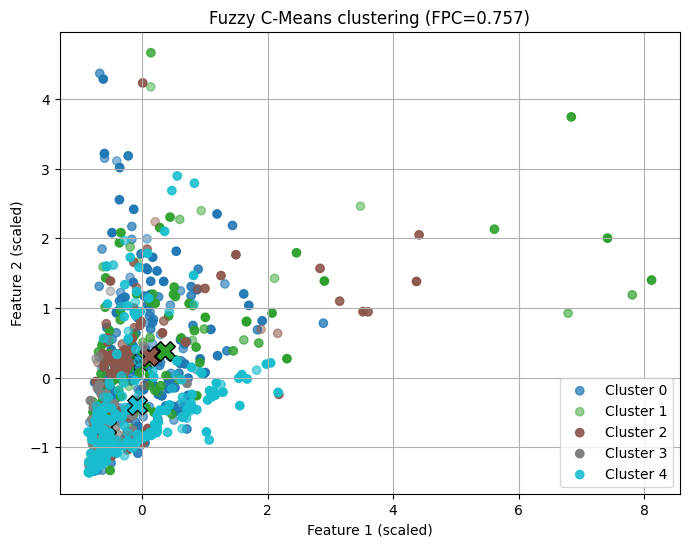

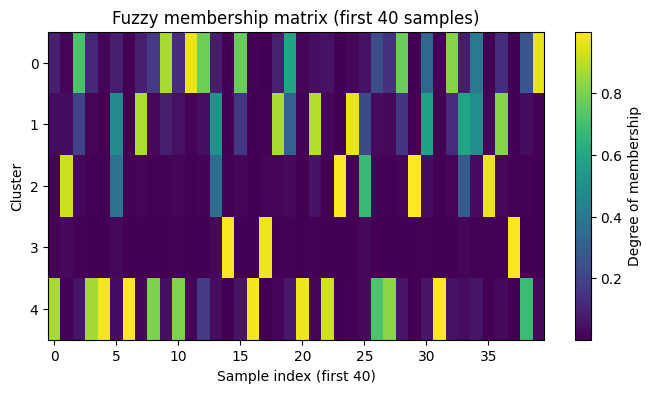

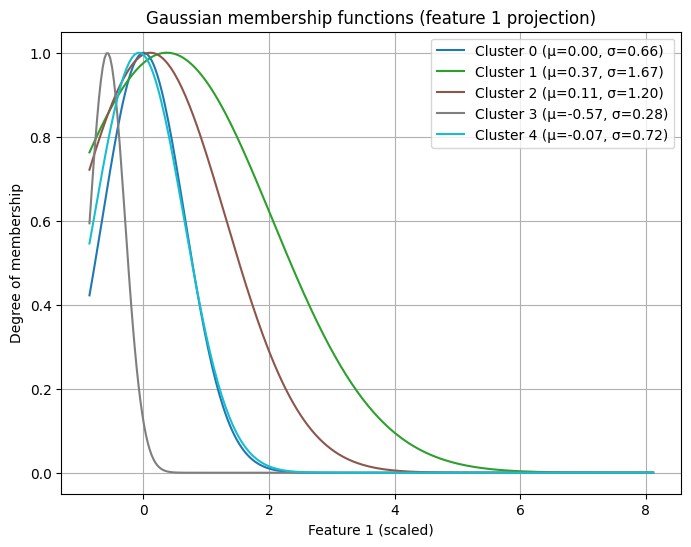

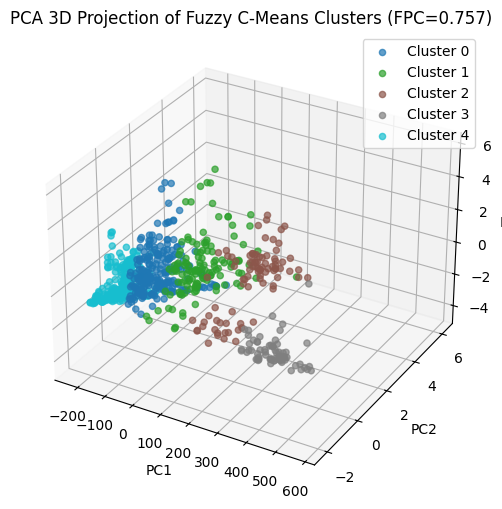

In [88]:
def global_firing_strengths(X, centers, sigmas, agg_prob=False):
    """
    Computes the normalized fuzzy firing strengths (membership activations)
    for each sample and each global FCM rule.

    Parameters
    ----------
    X : array-like, shape (N, D)
        Scaled and feature-selected input samples.
    centers, sigmas : array-like, shape (R, D)
        Cluster centers and spreads (from global FCM), excluding the target column.
    agg_prob : bool, optional
        If True, aggregates distances using the L2 norm (probabilistic intersection).
        If False, approximates the t-norm 'min' operation using the max of normalized distances.

    Returns
    -------
    Wn : ndarray, shape (N, R)
        Normalized firing strengths.
    W : ndarray, shape (N, R)
        Raw, unnormalized firing strengths.
    """

    # Convert inputs to PyTorch tensors
    X_t = torch.as_tensor(X, dtype=torch.float32)
    C   = torch.as_tensor(centers, dtype=torch.float32)
    S   = torch.as_tensor(sigmas,  dtype=torch.float32)

    # Compute normalized absolute difference between samples and cluster centers
    # Shape: (N samples, R rules, D features)
    diff = torch.abs((X_t.unsqueeze(1) - C.unsqueeze(0)) / (S.unsqueeze(0) + 1e-6))

    # Aggregate across features to get a single distance per rule
    if agg_prob:
        dist = torch.norm(diff, dim=-1)           # (N, R) — probabilistic aggregation (L2 norm)
    else:
        dist = torch.max(diff, dim=-1).values     # (N, R) — min t-norm approximation using max distance

    # Compute Gaussian activation for each rule
    W = torch.exp(-0.5 * dist**2)                 # (N, R) — raw firing strengths

    # Normalize rule activations for each sample
    Wn = W / (W.sum(dim=1, keepdim=True) + 1e-9)  # ensures row-wise normalization

    return Wn.numpy(), W.numpy()


# Run global FCM clustering and extract results
centers_global, sigmas_global = fcm_global_init(X_train_s, y_train, n_rules=N_RULES, m=M_FCM, seed=0)

# For ANFIS, only the input feature dimensions are used (exclude target y dimension)
centers_inp = centers_global[:, :-1]
sigmas_inp  = sigmas_global[:, :-1]


In [89]:
# ---------------------------------------------------------
# 3) TSK-0 and TSK-1 models (fixed antecedents; closed consequents)
# ---------------------------------------------------------

def ts0_fit_predict_global(Xtr, ytr, Xte, centers, sigmas, agg_prob=False):
    """
    Fits and predicts a zero-order Takagi–Sugeno–Kang (TSK-0) fuzzy model 
    using fixed antecedents from global FCM clustering.
    
    Each rule outputs a constant value (no dependence on inputs).
    Consequent parameters are estimated by regularized least squares.

    Parameters
    ----------
    Xtr, Xte : ndarray
        Scaled and feature-selected training and test sets.
    ytr : ndarray
        Training target values.
    centers, sigmas : ndarray
        Cluster centers and spreads from FCM (input dimensions only).
    agg_prob : bool, optional
        Aggregation mode for fuzzy membership computation (see `global_firing_strengths`).

    Returns
    -------
    yhat_train, yhat_test : ndarray
        Predicted outputs for training and test sets.
    """
    # Compute normalized rule activations (firing strengths) for train and test
    Wn_tr, _ = global_firing_strengths(Xtr, centers, sigmas, agg_prob=agg_prob)
    Wn_te, _ = global_firing_strengths(Xte, centers, sigmas, agg_prob=agg_prob)

    # Solve for rule consequents (constants per rule) using ridge regression
    lam = 1e-6
    A = Wn_tr
    c = np.linalg.lstsq(A.T @ A + lam * np.eye(A.shape[1]), A.T @ ytr, rcond=None)[0]

    # Return predictions for training and test sets
    return A @ c, Wn_te @ c


def ts1_fit_predict_global(Xtr, ytr, Xte, centers, sigmas, agg_prob=False):
    """
    Fits and predicts a first-order Takagi–Sugeno–Kang (TSK-1) fuzzy model 
    using fixed antecedents from global FCM clustering.

    Each rule defines a local linear model y = a·x + b.
    Parameters (a, b) are estimated using ridge regression.

    Parameters
    ----------
    Xtr, Xte : ndarray
        Scaled and feature-selected training and test sets.
    ytr : ndarray
        Training target values.
    centers, sigmas : ndarray
        Cluster centers and spreads from FCM (input dimensions only).
    agg_prob : bool, optional
        Aggregation mode for fuzzy membership computation.

    Returns
    -------
    yhat_train, yhat_test : ndarray
        Predicted outputs for training and test sets.
    """

    # Compute normalized rule activations (firing strengths) for train and test
    Wn_tr, _ = global_firing_strengths(Xtr, centers, sigmas, agg_prob=agg_prob)
    Wn_te, _ = global_firing_strengths(Xte, centers, sigmas, agg_prob=agg_prob)

    # Helper to build the extended input matrix with weighted features per rule
    def build_Z(X, Wn):
        N, D = X.shape
        R = Wn.shape[1]
        cols = []
        for r in range(R):
            wr = Wn[:, [r]]
            cols.append(wr * X)   # rule-weighted input features
            cols.append(wr)       # rule-specific bias term
        return np.concatenate(cols, axis=1)  

    # Construct weighted design matrices for train and test
    Ztr = build_Z(Xtr, Wn_tr)
    Zte = build_Z(Xte, Wn_te)

   
    lam = 1e-2
    A = Ztr
    theta = np.linalg.lstsq(A.T @ A + lam * np.eye(A.shape[1]), A.T @ ytr, rcond=None)[0]

    # Return predictions for training and test sets
    return Ztr @ theta, Zte @ theta


def rmse(a, b):
    """Root Mean Squared Error (RMSE) metric."""
    return math.sqrt(mean_squared_error(a, b))


# --- Quick validation check for the TSK models ---
_, yhat_val_ts0 = ts0_fit_predict_global(X_train_s, y_train, X_val_s, centers_inp, sigmas_inp, agg_prob=AGG_PROB)
_, yhat_val_ts1 = ts1_fit_predict_global(X_train_s, y_train, X_val_s, centers_inp, sigmas_inp, agg_prob=AGG_PROB)

print(f"TS-0  RMSE (val): {rmse(y_val, yhat_val_ts0):.4f}")
print(f"TS-1  RMSE (val): {rmse(y_val, yhat_val_ts1):.4f}")


TS-0  RMSE (val): 73.6546
TS-1  RMSE (val): 18.8810


In [90]:
# ===========================================================
# 4) ANFIS (Adaptive Neuro-Fuzzy Inference System) – TSK model with hybrid training
# ===========================================================

class GaussianMF(nn.Module):
    """
    Antecedent layer: Gaussian membership functions per rule and per input dimension.
    Each rule has its own center and spread (σ) parameters, learned during training.
    """

    def __init__(self, centers, sigmas, agg_prob=False):
        super().__init__()
        # centers/sigmas shape: (n_rules, n_features)
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas  = nn.Parameter(torch.tensor(sigmas,  dtype=torch.float32))
        self.agg_prob = agg_prob

    def forward(self, x):
        """
        Compute fuzzy membership activations (firing strengths) for each rule.
        x : (batch_size, n_features)
        """
        # Compute normalized distance to each rule’s Gaussian center
        diff = torch.abs((x.unsqueeze(1) - self.centers.unsqueeze(0)) / (self.sigmas.unsqueeze(0) + 1e-6))
        
        # Aggregation:
        #   - Probabilistic (L2 norm) if agg_prob=True
        #   - Max (≈ t-norm min) otherwise
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)        # (batch, n_rules)
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules)

        # Gaussian membership value for each rule
        return torch.exp(-0.5 * dist ** 2)         # (batch, n_rules)


class TSK_Anfis(nn.Module):
    """
    TSK-1 (first-order Takagi–Sugeno–Kang) neuro-fuzzy model.
    Overall output:
        y = Σ_r [ w̄_r * (a_rᵀ x + b_r) ]
    where:
        - w̄_r : normalized firing strength of rule r
        - a_r, b_r : consequent parameters (linear coefficients + bias)
    """

    def __init__(self, n_inputs, n_rules, centers, sigmas, agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules  = n_rules

        # Antecedent layer (Gaussian MFs initialized from FCM global clusters)
        self.mfs = GaussianMF(centers, sigmas, agg_prob=agg_prob)

        # Consequent parameters: (n_inputs + 1, n_rules) → linear coefficients + bias per rule
        self.consequents = nn.Parameter(torch.randn(n_inputs + 1, n_rules))

    def forward(self, x):
        """
        Forward pass through the ANFIS network.
        Returns:
            y           : model output (batch, 1)
            norm_f      : normalized firing strengths (batch, n_rules)
            rule_outputs: individual rule outputs (batch, n_rules)
        """
        batch = x.shape[0]

        # 1️⃣ Compute firing strengths for each rule
        firing = self.mfs(x)                                # (batch, n_rules)
        norm_f = firing / (firing.sum(dim=1, keepdim=True) + 1e-9)

        # 2️⃣ Compute rule outputs (local linear models)
        x_aug = torch.cat([x, torch.ones(batch, 1, dtype=x.dtype, device=x.device)], dim=1)  # add bias term
        rule_outputs = torch.einsum("bi,ir->br", x_aug, self.consequents)  # (batch, n_rules)

        # 3️⃣ Combine rules weighted by their normalized activations
        y = torch.sum(norm_f * rule_outputs, dim=1, keepdim=True)  # (batch, 1)
        return y, norm_f, rule_outputs


@torch.no_grad()
def train_ls(model: TSK_Anfis, X, y):
    """
    Step B of the hybrid training: 
    Recalibrate the consequents (a_r, b_r) using Least Squares (LS) 
    given the current membership activations (antecedents fixed).
    """
    y = y.reshape(-1, 1)
    y_t = torch.as_tensor(y, dtype=torch.float32, device=X.device)

    y_pred, norm_fs, _ = model(X)
    X_aug = torch.cat([X, torch.ones(X.shape[0], 1, device=X.device)], dim=1)  # (N, D+1)

    # Build design matrix Φ by concatenating (normalized firing * X_aug) for all rules
    N, R = norm_fs.shape
    Dp1 = X_aug.shape[1]
    Phi = torch.empty((N, R * Dp1), dtype=torch.float32, device=X.device)
    for r in range(R):
        Phi[:, r*Dp1:(r+1)*Dp1] = X_aug * norm_fs[:, r:r+1]

    # Solve least squares: θ = (ΦᵀΦ)^(-1) Φᵀ y
    theta = torch.linalg.lstsq(Phi, y_t).solution  # (R*(D+1), 1)
    theta = theta.view(R, Dp1).transpose(0, 1)     # reshape → (D+1, R)
    model.consequents.data.copy_(theta)


def train_gd(model: TSK_Anfis, X, y, epochs=100, lr=1e-3):
    """
    Step A of the hybrid training:
    Update antecedent parameters (centers, sigmas) using Gradient Descent,
    keeping consequents fixed.
    """
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        opt.zero_grad()
        y_pred, _, _ = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        opt.step()


def train_hybrid_anfis(model: TSK_Anfis, X, y, max_iters=ANFIS_MAX_ITERS, gd_epochs=ANFIS_GD_EPOCHS, lr=ANFIS_LR):
    """
    Classical hybrid ANFIS training (Jang, 1993):
        Iteratively alternates between:
          A) Gradient Descent (GD) on antecedent parameters (membership functions)
          B) Least Squares (LS) on consequent parameters (linear coefficients)
    """
    y = y.reshape(-1, 1)
    y_t = torch.tensor(y, dtype=torch.float32, device=X.device)

    # --- Initial step: LS estimation of consequents ---
    train_ls(model, X, y_t)

    for it in range(max_iters):
        # A) Gradient Descent on antecedents (freeze consequents)
        model.consequents.requires_grad = False
        for p in model.mfs.parameters():
            p.requires_grad = True
        train_gd(model, X, y_t, epochs=gd_epochs, lr=lr)

        # B) Least Squares on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        for p in model.mfs.parameters():
            p.requires_grad = False
        train_ls(model, X, y_t)

        # Reactivate antecedent parameters for next iteration
        for p in model.mfs.parameters():
            p.requires_grad = True


# ---- Instantiate and train the ANFIS (TSK model) using global FCM initialization ----
anfis = TSK_Anfis(
    n_inputs=n_features,
    n_rules=N_RULES,
    centers=centers_inp,
    sigmas=sigmas_inp,
    agg_prob=AGG_PROB
).to(device)


In [91]:
# -----------------------------------------------------------
# 5) Train and validate the ANFIS (TSK-hybrid) model
# -----------------------------------------------------------

# Convert NumPy arrays to PyTorch tensors and move them to the selected device (CPU/GPU)
Xtr_t = torch.tensor(X_train_s, dtype=torch.float32, device=device)
ytr_t = torch.tensor(y_train,   dtype=torch.float32, device=device)
Xval_t = torch.tensor(X_val_s,  dtype=torch.float32, device=device)
yval_t = torch.tensor(y_val,    dtype=torch.float32, device=device)

# --- Hybrid training ---
# Alternates between gradient descent (for membership parameters)
# and least squares (for linear consequents)
train_hybrid_anfis(anfis,Xtr_t,ytr_t,max_iters=ANFIS_MAX_ITERS,gd_epochs=ANFIS_GD_EPOCHS,lr=ANFIS_LR)

# --- Validation phase ---
anfis.eval()  # disable gradient tracking during evaluation
with torch.no_grad():
    # Model outputs predicted calorie values for validation set
    yhat_val_anfis = anfis(Xval_t)[0].cpu().numpy()

# --- Performance evaluation ---
print(f"ANFIS (TSK-hybrid) RMSE (val): {rmse(y_val, yhat_val_anfis):.4f}")



C:\Users\Gonçalo Rosa\AppData\Local\Temp\ipykernel_1568\2748470948.py:132: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_t = torch.tensor(y, dtype=torch.float32, device=X.device)


ANFIS (TSK-hybrid) RMSE (val): 10.9835


In [92]:
# --------------------------------------------------------
# 5) Meta-model: stacking ensemble of TS-0 / TS-1 / ANFIS   
# --------------------------------------------------------

# --- Generate base model predictions (on validation and test sets) ---

# TS-0 (zero-order TSK) predictions
_, yhat_val_ts0  = ts0_fit_predict_global(X_train_s, y_train, X_val_s, centers_inp, sigmas_inp, agg_prob=AGG_PROB)
_, yhat_test_ts0 = ts0_fit_predict_global(X_train_s, y_train, X_test_s, centers_inp, sigmas_inp, agg_prob=AGG_PROB)

# TS-1 (first-order TSK) predictions
_, yhat_val_ts1  = ts1_fit_predict_global(X_train_s, y_train, X_val_s, centers_inp, sigmas_inp, agg_prob=AGG_PROB)
_, yhat_test_ts1 = ts1_fit_predict_global(X_train_s, y_train, X_test_s, centers_inp, sigmas_inp, agg_prob=AGG_PROB)

# ANFIS (hybrid neuro-fuzzy) predictions
with torch.no_grad():
    yhat_test_anfis = anfis(torch.tensor(X_test_s, dtype=torch.float32, device=device))[0].cpu().numpy()

# --- Build meta-model training and test sets ---

# Combine validation predictions from base models into meta-level training features
Z_train_meta = np.concatenate([yhat_val_ts0, yhat_val_ts1, yhat_val_anfis], axis=1)
y_train_meta = y_val

# Combine test predictions into meta-level test features
Z_test_meta = np.concatenate([yhat_test_ts0, yhat_test_ts1, yhat_test_anfis], axis=1)

# --- Train meta-learner (Ridge Regression) ---
from sklearn.linear_model import Ridge
meta = Ridge(alpha=1.0)
meta.fit(Z_train_meta, y_train_meta)

# Final ensemble predictions on test data
yhat_test_meta = meta.predict(Z_test_meta).reshape(-1, 1)



In [93]:
def predict_calories(features_row_np):
    """
    Predicts the caloric value of a single food item based on its nutritional features,
    using the full stacked fuzzy ensemble (TSK-0, TSK-1, ANFIS, and Ridge meta-model).

    
    """
    # --- Preprocess input ---
    # Scale all features using the training scaler
    x_full = scaler.transform(features_row_np.reshape(1, -1))
    # Select only the top-k features used in model training
    x = x_full[:, top_idx]

    # --- Base fuzzy model predictions ---
    # TSK-0 (constant per rule)
    _, ts0 = ts0_fit_predict_global(X_train_s, y_train, x, centers_inp, sigmas_inp, agg_prob=AGG_PROB)
    # TSK-1 (local linear per rule)
    _, ts1 = ts1_fit_predict_global(X_train_s, y_train, x, centers_inp, sigmas_inp, agg_prob=AGG_PROB)

    # --- ANFIS (hybrid neuro-fuzzy) prediction ---
    with torch.no_grad():
        anf = anfis(torch.tensor(x, dtype=torch.float32, device=device))[0].cpu().numpy()

    # --- Meta-model (Ridge ensemble) prediction ---
    z = np.concatenate([ts0, ts1, anf], axis=1)
    meta_pred = meta.predict(z).reshape(-1, 1)

    # --- Return results in a structured dictionary ---
    return {
        "ts0":   float(ts0.ravel()[0]),
        "ts1":   float(ts1.ravel()[0]),
        "anfis": float(anf.ravel()[0]),
        "meta":  float(meta_pred.ravel()[0])
    }


In [94]:
#Prints the RMSE for each model
print("\n================= TEST RMSE =================")
print(f"TS-0    : {rmse(y_test, yhat_test_ts0):.4f}")
print(f"TS-1    : {rmse(y_test, yhat_test_ts1):.4f}")
print(f"ANFIS   : {rmse(y_test, yhat_test_anfis):.4f}")
print(f"Meta(R) : {rmse(y_test, yhat_test_meta):.4f}")



================= TEST RMSE =================
TS-0    : 63.4523
TS-1    : 15.3562
ANFIS   : 9.7559
Meta(R) : 9.7939


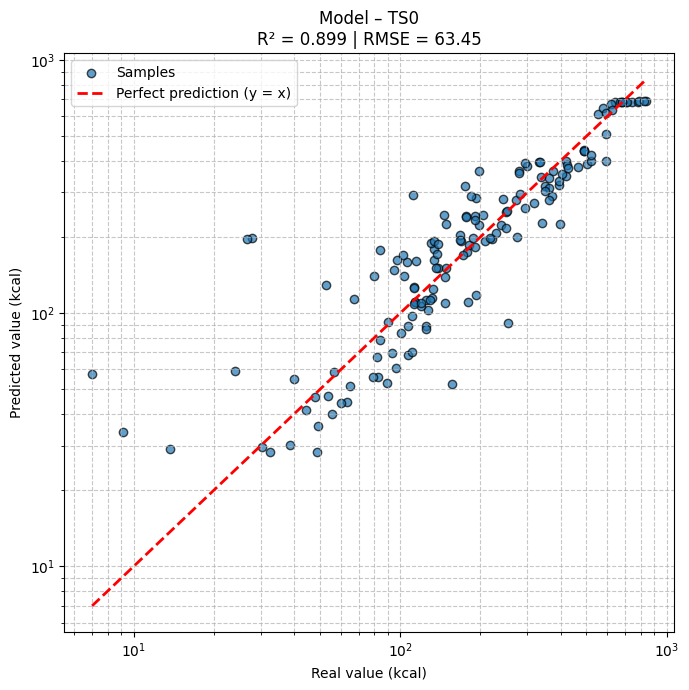

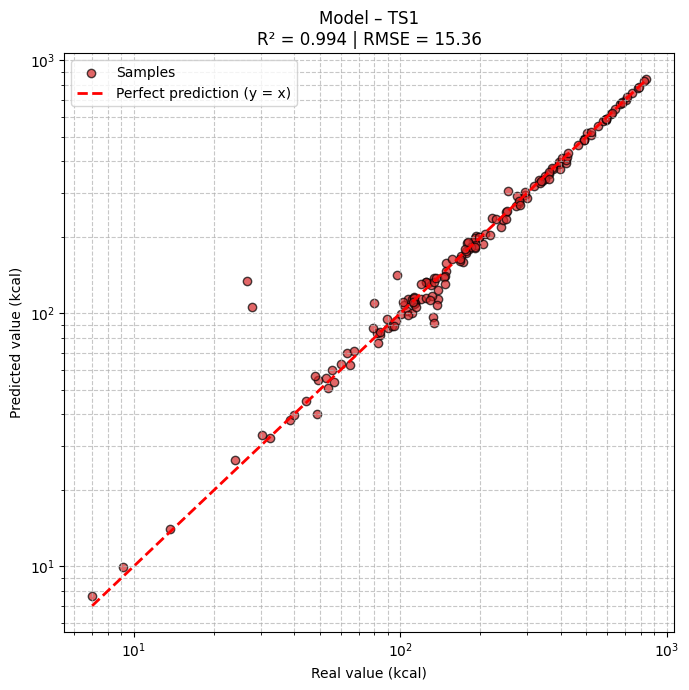

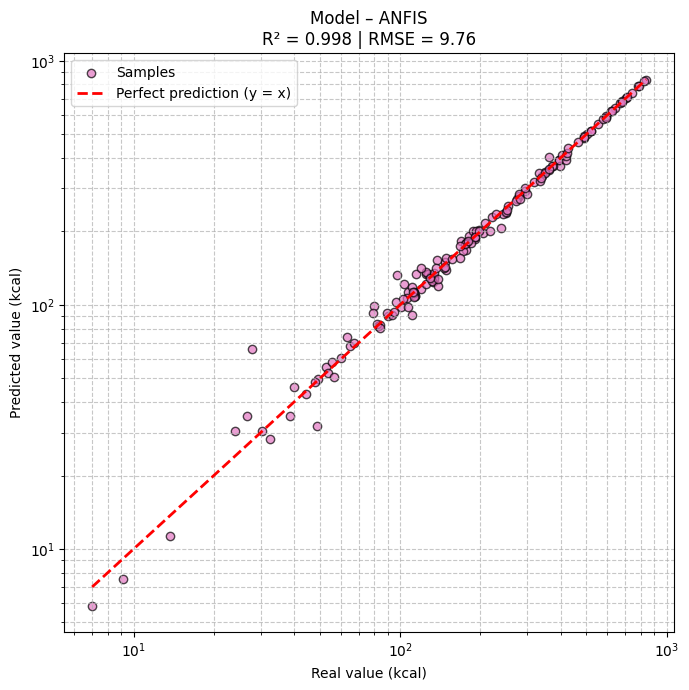

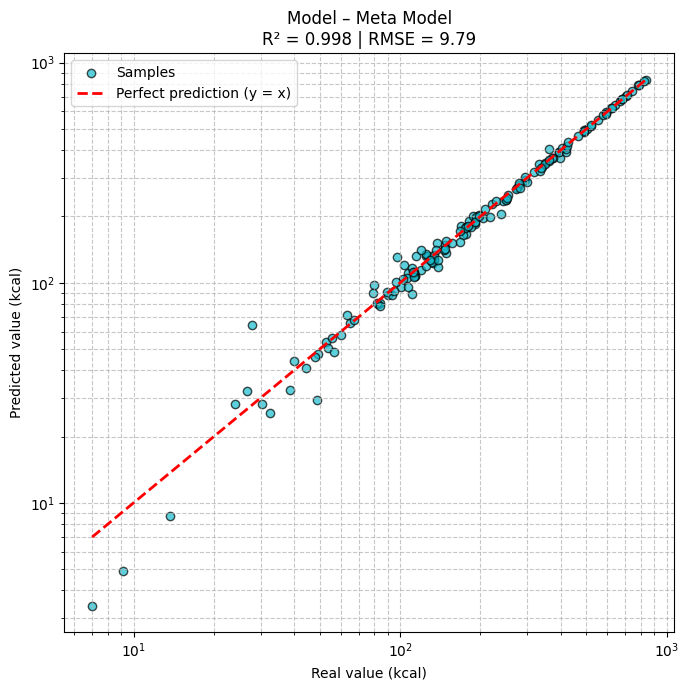

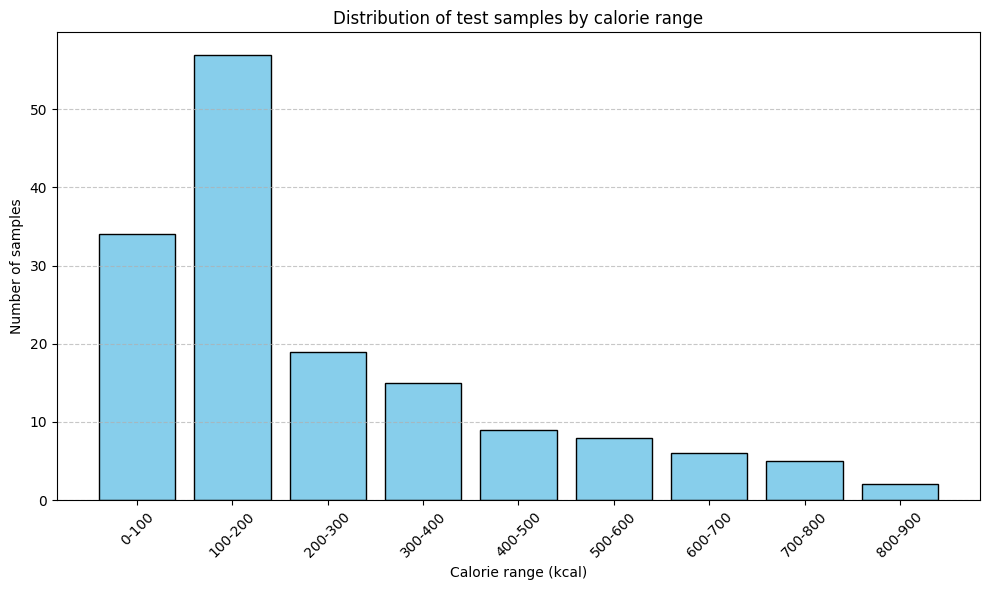

In [95]:
# ===========================================================
#  Real vs Predicted plots (4 separate figures) – Log scale
# ===========================================================

def plot_real_vs_pred(y_true, y_pred, model_name, color):
    """
    Creates a scatter plot comparing real and predicted values,
    with a perfect prediction line (y = x) as reference.
    Uses logarithmic scales on both axes.
    """
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    plt.figure(figsize=(7,7))
    plt.scatter(y_true, y_pred, alpha=0.7, edgecolors='k', color=color, label='Samples')
    plt.plot([min(y_true), max(y_true)],
             [min(y_true), max(y_true)],
             'r--', lw=2, label='Perfect prediction (y = x)')

    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    r2 = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

    plt.title(f'{model_name}\nR² = {r2:.3f} | RMSE = {rmse:.2f}', fontsize=12)
    plt.xlabel('Real value (kcal)')
    plt.ylabel('Predicted value (kcal)')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


# Colors for consistency
colors = plt.cm.tab10(np.linspace(0, 1, 4))

# --- Model A: Global FCM (TS0)
plot_real_vs_pred(y_test, yhat_test_ts0, "Model – TS0", colors[0])

# --- Model B: Local FCM (TS1)
plot_real_vs_pred(y_test, yhat_test_ts1, "Model – TS1", colors[1])

# --- Model C: ANFIS
plot_real_vs_pred(y_test, yhat_test_anfis, "Model – ANFIS", colors[2])

# --- Model D: Meta Model
plot_real_vs_pred(y_test, yhat_test_meta, "Model – Meta Model", colors[3])


# ===========================================================
#  Bar chart: Distribution of test samples by calorie range
# ===========================================================
y_true = y_test.flatten()
bins = np.arange(0, np.ceil(y_true.max() / 100) * 100 + 100, 100)
counts, _ = np.histogram(y_true, bins=bins)
bin_labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]

plt.figure(figsize=(10,6))
plt.bar(bin_labels, counts, color='skyblue', edgecolor='black')
plt.xlabel('Calorie range (kcal)')
plt.ylabel('Number of samples')
plt.title('Distribution of test samples by calorie range')
plt.xticks(rotation=45) 
plt.grid(axis='y', which="both", linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
